In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings

In [2]:
from featureExtraction import *
from dataAnalyzer import *
from private_tool import *
from dataHandler import *

In [3]:
warnings.filterwarnings('ignore')

In [4]:
experimentNum = 9
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [5]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [6]:
for i in range(len(trialsByClasses)):
    for j in trialsByClasses[i].keys():
        for k in range(len(trialsByClasses[i][j])):
            for l in range(len(trialsByClasses[i][j][k])):
                trialsByClasses[i][j][k][l] = trialsByClasses[i][j][k][l][749:1500]


In [7]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [8]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=8, 
                                                                cutoff_high=12)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [9]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key: np.array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# i: experiment
# j: trial

In [10]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [11]:
experimentIdx = 3

In [12]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [13]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [14]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [15]:
len(CSP_passed_left_data)

25

In [16]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [17]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]
np.array(CSP_passed_left_data).shape

(25, 49, 751)

In [18]:
CSP_passed_left_data = np.array([i.T for i in np.array(CSP_passed_left_data).T]).T
CSP_passed_right_data = np.array([i.T for i in np.array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = np.array([i.T for i in np.array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = np.array([i.T for i in np.array(CSP_passed_foot_data).T]).T
CSP_passed_left_data.shape

(49, 25, 751)

In [19]:
# m = 12

# leftVarRatioDF = twoMDimensionalFeature(CSP_passed_left_data, channelNum, minTrialsNum, m)
# rightVarRatioDF = twoMDimensionalFeature(CSP_passed_right_data, channelNum, minTrialsNum, m)
# tongueVarRatioDF = twoMDimensionalFeature(CSP_passed_tongue_data, channelNum, minTrialsNum, m)
# footVarRatioDF = twoMDimensionalFeature(CSP_passed_foot_data, channelNum, minTrialsNum, m)

# VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
# labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

# VarRatioDF = VarRatioDF.reset_index()
# VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
# VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
# VarRatioDF

In [20]:
leftVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_left_data))
rightVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_right_data))
tongueVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_tongue_data))
footVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_foot_data))

VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
VarRatioDF.columns = [f"{n}" for n in range(25)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,target
0,219.441860,197.157268,215.649691,229.079118,214.170741,214.783254,177.836902,210.570048,222.067393,235.191339,...,248.343849,235.360772,269.127219,288.163437,275.090509,265.907958,137.718123,253.433763,204.852259,0
1,321.203246,249.519438,298.012592,323.489804,319.013228,296.264096,172.708560,216.279656,258.688892,285.025062,...,251.247704,231.461781,295.691559,277.579282,279.011641,337.482344,189.431404,248.616257,213.827887,0
2,244.494405,222.326610,246.159020,268.731920,273.753079,258.763539,178.532081,235.926370,267.054513,290.253860,...,323.813684,333.100751,332.159455,351.606846,346.084628,350.052829,110.699944,150.694946,108.911424,0
3,252.831408,222.309533,239.313737,252.791918,231.249415,206.176642,160.092915,212.412567,227.338003,239.936869,...,244.346804,235.542101,313.662347,321.011519,326.540037,366.682592,164.009035,223.859690,174.628899,0
4,242.514438,237.540669,265.639826,270.992925,247.855184,217.878858,181.021585,226.135837,248.262934,268.097970,...,238.261836,238.773864,267.670423,289.037860,292.876545,303.962800,141.266082,189.505196,162.007870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,221.421408,188.494149,211.396249,226.722698,207.250770,179.700862,147.398101,203.650756,219.707405,245.024603,...,323.829197,336.390120,380.844880,407.469099,446.854625,478.702053,127.633686,157.656449,148.246997,3
192,225.203858,211.478633,240.600629,259.948400,257.790008,256.106244,173.327355,213.577152,237.542416,269.601198,...,269.719718,285.129455,282.256653,308.639954,339.501846,368.231005,101.364321,137.924048,134.223626,3
193,234.162812,211.151734,217.900748,247.667520,237.898985,239.388394,156.927931,176.221957,191.076429,232.059030,...,279.505376,329.130455,298.276040,321.127169,386.138691,428.322761,186.808993,261.580386,222.462159,3
194,286.058665,246.802198,288.097603,308.421895,301.389954,294.169367,178.509741,237.985782,275.744301,309.616787,...,315.128499,315.235408,339.087096,357.639446,365.128965,376.850323,155.340059,168.500483,157.387959,3


In [21]:
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.731558,-0.645672,-0.721134,-0.779467,-0.923970,-0.581092,0.003246,-0.147597,-0.455663,-0.665071,...,-0.098721,-0.412856,-0.572546,-0.318004,-0.179359,-0.530419,-0.849189,-0.694552,1.223130,0.462864
1,1.612893,0.707411,1.201580,1.314193,1.537543,1.478566,-0.162706,-0.000219,0.400269,0.436839,...,-0.403458,-0.352866,-0.649420,0.157179,-0.360360,-0.469797,0.173945,0.880067,1.097464,0.685872
2,-0.154380,0.004725,-0.008911,0.099877,0.474916,0.530634,0.025742,0.506907,0.595793,0.552457,...,1.040825,1.146237,1.354523,0.809516,0.905598,0.567163,0.353637,-1.517229,-1.456831,-1.920876
3,0.037694,0.004284,-0.168711,-0.253610,-0.522994,-0.798648,-0.570946,-0.100037,-0.332476,-0.560139,...,-0.315216,-0.495429,-0.568971,0.478640,0.382382,0.265000,0.591354,0.105981,0.451685,-0.288064
4,-0.199996,0.397870,0.445856,0.150017,-0.133120,-0.502842,0.106302,0.254191,0.156589,0.062552,...,-0.494950,-0.621135,-0.505253,-0.344063,-0.164405,-0.255444,-0.305207,-0.586520,-0.444458,-0.601645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,-0.685952,-0.869535,-0.820428,-0.831723,-1.086439,-1.467898,-0.981747,-0.326199,-0.510822,-0.447640,...,0.904924,1.146557,1.419377,1.680400,1.860909,2.125085,2.192638,-1.001613,-1.275239,-0.943547
192,-0.598809,-0.275596,-0.138669,-0.094907,0.100132,0.463463,-0.142682,-0.069977,-0.093975,0.095791,...,-0.367085,0.028737,0.408707,-0.083145,0.170814,0.465392,0.613488,-1.801490,-1.789962,-1.291971
193,-0.392406,-0.284043,-0.668584,-0.367249,-0.366874,0.040873,-0.673364,-1.034198,-1.179996,-0.734331,...,-0.826139,0.230894,1.276244,0.203410,0.384360,1.186406,1.472482,0.800217,1.435636,0.900399
194,0.803207,0.637196,0.970120,0.980045,1.123780,1.425616,0.025019,0.560065,0.798894,0.980604,...,1.064889,0.966814,1.002285,0.933437,1.008763,0.861592,0.736699,-0.157981,-0.992370,-0.716431


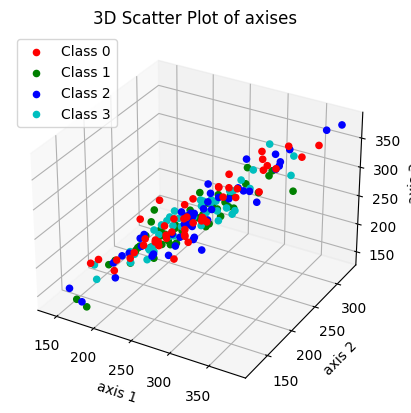

In [22]:
plotDF3D(data=VarRatioDF, num_of_classes=4)

In [23]:
# cross_validation("linear", VarRatioDF.drop(['label'], axis=1).values, labelDF)
# cross_validation("rbf", VarRatioDF.drop(['label'], axis=1).values, labelDF)

In [24]:
# n_componunts = 3
# PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
# principalDF = PCA.principalDf

In [25]:
# sum(PCA.explained_variance_ratio_())

In [26]:
# cross_validation("linear", principalDF, labelDF)
# cross_validation("rbf", principalDF, labelDF)

In [27]:
# df = pd.concat([principalDF, labelDF], axis=1)
# plotDF3D(data=df, num_of_classes=4)

In [28]:
np.save(currDir+"/test.npy", VarRatioDF)

In [29]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(x, labelDF, 3, "eigen")), labelDF], axis=1)
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [30]:
cross_validation("linear", LDA_DF.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.5866666666666667
교차검증 평균:  0.5764102564102564


0.5764102564102564

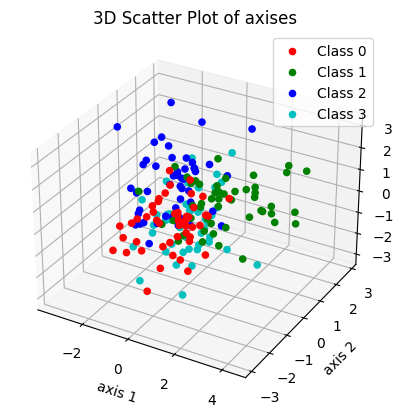

In [31]:
plotDF3D(data=LDA_DF, num_of_classes=4)

In [32]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [33]:
cross_validation("linear", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.5967948717948718
교차검증 평균:  0.5866666666666667


0.5866666666666667

In [34]:
np.save(currDir+"/test.npy", LDA_DF_Scaled)